In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier, Pool
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Подготовка данных

In [2]:
dataset_path = 'data/creditcard.csv'
dataset = pd.read_csv(dataset_path, sep='[,]', engine='python')

In [3]:
df = dataset.copy()
display(df)

,"""Time""","""V1""","""V2""","""V3""","""V4""","""V5""","""V6""","""V7""","""V8""","""V9""",...,"""V21""","""V22""","""V23""","""V24""","""V25""","""V26""","""V27""","""V28""","""Amount""","""Class"""
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,"""0"""
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,"""0"""
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,"""0"""
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,"""0"""
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,"""0"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,"""0"""
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,"""0"""
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,"""0"""
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,"""0"""


In [4]:
df.columns = df.columns.str.replace(r'\W', '', regex=True)
df.loc[:, 'Class'] = df.loc[:, 'Class'].str.replace(r'\W', '', regex=True)
df = df.astype({'Class': 'int'})
display(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Балансировка датасета
Соотношение значений Class исходного датасета

[Text(0, 0, '492')]

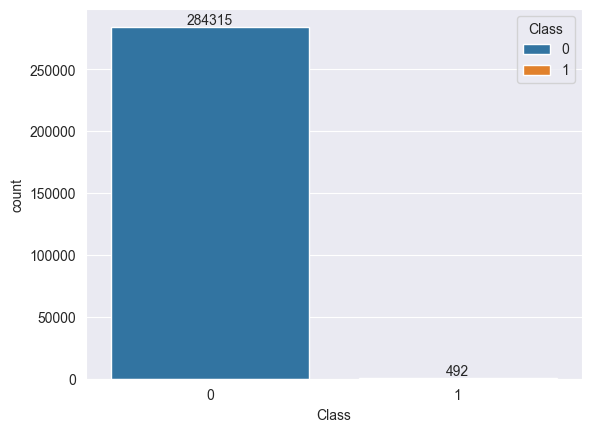

In [5]:
ax = sns.countplot(x='Class', data=df, hue='Class')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

Разделим данные

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.25, random_state=0)

Применим Random Undersampling для класса большинства

In [7]:
rus = RandomUnderSampler(random_state=0, sampling_strategy='not minority')
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

И Random Oversampling для класса меньшинства

In [8]:
ros = RandomOverSampler(random_state=0, sampling_strategy='not majority')
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

##### Используем CatBoosting в качестве модели для отбора признаков

In [9]:
# Accuracy
params = {'iterations': 1000, 'use_best_model': True, 'eval_metric': 'Accuracy'}
model = CatBoostClassifier(**params)

model.fit(X_train_resampled, y_train_resampled,
          eval_set=(X_test_resampled, y_test_resampled),
          verbose=50)

Learning rate set to 0.029457
0:	learn: 0.9368280	test: 0.9098084	best: 0.9098084 (0)	total: 178ms	remaining: 2m 57s
50:	learn: 0.9663978	test: 0.9373400	best: 0.9375299 (44)	total: 669ms	remaining: 12.4s
100:	learn: 0.9825269	test: 0.9334501	best: 0.9382825 (84)	total: 1.27s	remaining: 11.3s
150:	learn: 0.9932796	test: 0.9328100	best: 0.9382825 (84)	total: 1.88s	remaining: 10.6s
200:	learn: 0.9973118	test: 0.9365944	best: 0.9409063 (186)	total: 2.71s	remaining: 10.8s
250:	learn: 0.9986559	test: 0.9399918	best: 0.9409063 (186)	total: 3.38s	remaining: 10.1s
300:	learn: 1.0000000	test: 0.9397386	best: 0.9409063 (186)	total: 4.4s	remaining: 10.2s
350:	learn: 1.0000000	test: 0.9348710	best: 0.9409063 (186)	total: 5.21s	remaining: 9.64s
400:	learn: 1.0000000	test: 0.9346107	best: 0.9409063 (186)	total: 6.21s	remaining: 9.28s
450:	learn: 1.0000000	test: 0.9343716	best: 0.9409063 (186)	total: 7.03s	remaining: 8.56s
500:	learn: 1.0000000	test: 0.9379519	best: 0.9409063 (186)	total: 7.86s	remai

In [10]:
cat_pred = model.predict(X_test_resampled)
print(metrics.classification_report(y_test_resampled, cat_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     71082
           1       0.98      0.90      0.94     71082

    accuracy                           0.94    142164
   macro avg       0.94      0.94      0.94    142164
weighted avg       0.94      0.94      0.94    142164


Построим гистограмму значимости фичей датасета

<Axes: ylabel='features'>

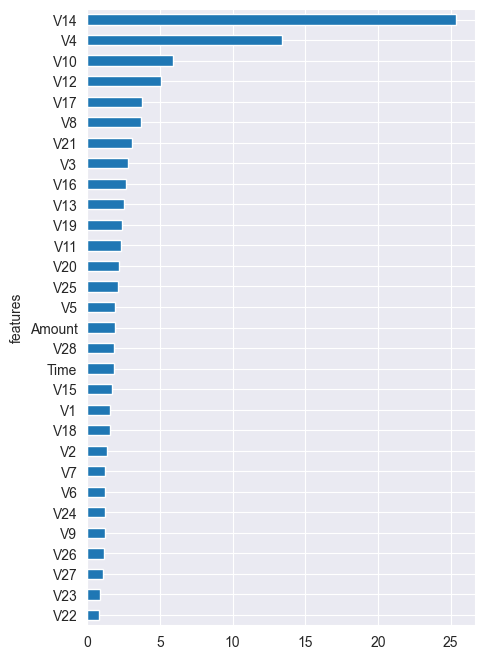

In [11]:
feature_names = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
                 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
fi = pd.DataFrame({'features': feature_names, 'w': model.feature_importances_})
fi.sort_values('w', inplace=True)
fi.set_index('features')['w'].plot(kind='barh', figsize=(5, 8), grid=True)

Выделим несколько наиболее значимых признаков:

['V14', 'V4', 'V10', 'V12', 'V17', 'V8', 'V21', 'V3']

In [12]:
print(f'Количество нулей: {np.sum(cat_pred == 0)}\n'
      f'Количество единиц: {np.sum(cat_pred == 1)}\n'
      f'Матрица ошибок:')
metrics.confusion_matrix(y_test_resampled, cat_pred)

Количество нулей: 76585
Количество единиц: 65579
Матрица ошибок:


array([[69633,  1449],
       [ 6952, 64130]], dtype=int64)

Соотношение значений Class сбалансированного датасета

[Text(0, 0, '65579')]

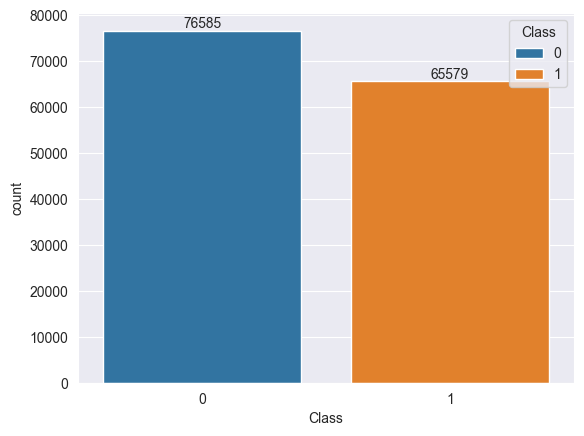

In [13]:
df_cat_pred = pd.DataFrame(cat_pred, columns=['Class'])
ax = sns.countplot(x='Class', data=df_cat_pred, hue='Class')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

# Прямой отбор фичей
Используем LogisticRegression для прямого отбора признаков

In [14]:
logreg = LogisticRegression(solver='lbfgs', max_iter=7600)
sfs_fs = sfs(logreg, k_features=5, forward=True, verbose=4, scoring='accuracy')
sfs_fs = sfs_fs.fit(X_train_resampled, y_train_resampled)
# Max score = 0.9435697442408852, k_features = 22

[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    2.2s

[2023-12-19 21:00:14] Features: 1/5 -- score: 0.9287774351532742[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.4s

[2023-12-19 21:00:16] Features: 2/5 -- score: 0.9354979140214038[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.7s

[2023-12-19 21:00:18] Features: 3/5 -- score: 0.9381915472519499[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.9s

[2023-12-19 21:00:19] Features: 4/5 -- score: 0.9381915472519499[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.1s

[2023-12-19 21:00:20] Features: 5/5 -- score: 0.9395338291311447

In [15]:
print(list(sfs_fs.k_feature_names_))

['V5', 'V8', 'V13', 'V14', 'V22']


# Обратный отбор фичей
Используем LogisticRegression для обратного отбора признаков

In [16]:
logreg = LogisticRegression(solver='lbfgs', max_iter=7600)
sfs_bs = sfs(logreg, k_features=7, forward=False, verbose=4, scoring='accuracy')
sfs_bs = sfs_bs.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    5.2s

[2023-12-19 21:00:29] Features: 29/7 -- score: 0.9341465626700527[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   21.8s

[2023-12-19 21:00:55] Features: 28/7 -- score: 0.9395156901868311[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   20.6s

[2023-12-19 21:01:19] Features: 27/7 -- score: 0.9422002539452204[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   19.2s

[2023-12-19 21:01:41] Features: 26/7 -- score: 0.9422002539452204[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    2.1s

[2023-12-19 21:01:43] Features: 25/7 -- score: 0.9435516052965717[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    2.1s

[2023-12-19 21:01:45] Features: 24/7 -- score: 0.9435516052965717[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.8s

[2023-12-19 21:01:47] Features: 23/7 -- score: 0.9449029566479231
[2023-12-19 21:01:49] Features: 22/7 -- score: 0.

In [17]:
print(list(sfs_bs.k_feature_names_))

['V2', 'V3', 'V4', 'V8', 'V10', 'V11', 'V14']


# Permutation Importance

In [18]:
logreg = LogisticRegression().fit(X_train_resampled, y_train_resampled)
logreg.score(X_test_resampled, y_test_resampled)

0.9416167243465293

In [19]:
params = {'iterations': 500, 'use_best_model': True, 'eval_metric': 'Accuracy'}
catboost = CatBoostClassifier(**params).fit(X_train_resampled, y_train_resampled,
                                         eval_set=(X_test_resampled, y_test_resampled),
                                         verbose=500)

Learning rate set to 0.039823
0:	learn: 0.9368280	test: 0.9098084	best: 0.9098084 (0)	total: 10.1ms	remaining: 5.03s
499:	learn: 1.0000000	test: 0.9348077	best: 0.9400200 (259)	total: 3.58s	remaining: 0us

bestTest = 0.9400199769
bestIteration = 259

Shrink model to first 260 iterations.


In [20]:
params = {'random_state': 0, 'n_repeats': 30}

perm_logreg_train = permutation_importance(logreg, X_train_resampled, y_train_resampled, **params)
perm_catboost_train = permutation_importance(catboost, X_train_resampled, y_train_resampled, **params)

perm_logreg_test = permutation_importance(logreg, X_test_resampled, y_test_resampled, **params)
perm_catboost_test = permutation_importance(catboost, X_test_resampled, y_test_resampled, **params)

In [21]:
results_train = [perm_logreg_train, perm_catboost_train]
results_test = [perm_logreg_test, perm_catboost_test]
names = ['Logistic Regression', 'Catboost Classifier']

Text(0, 0.5, 'Change in Mean Squared Error')

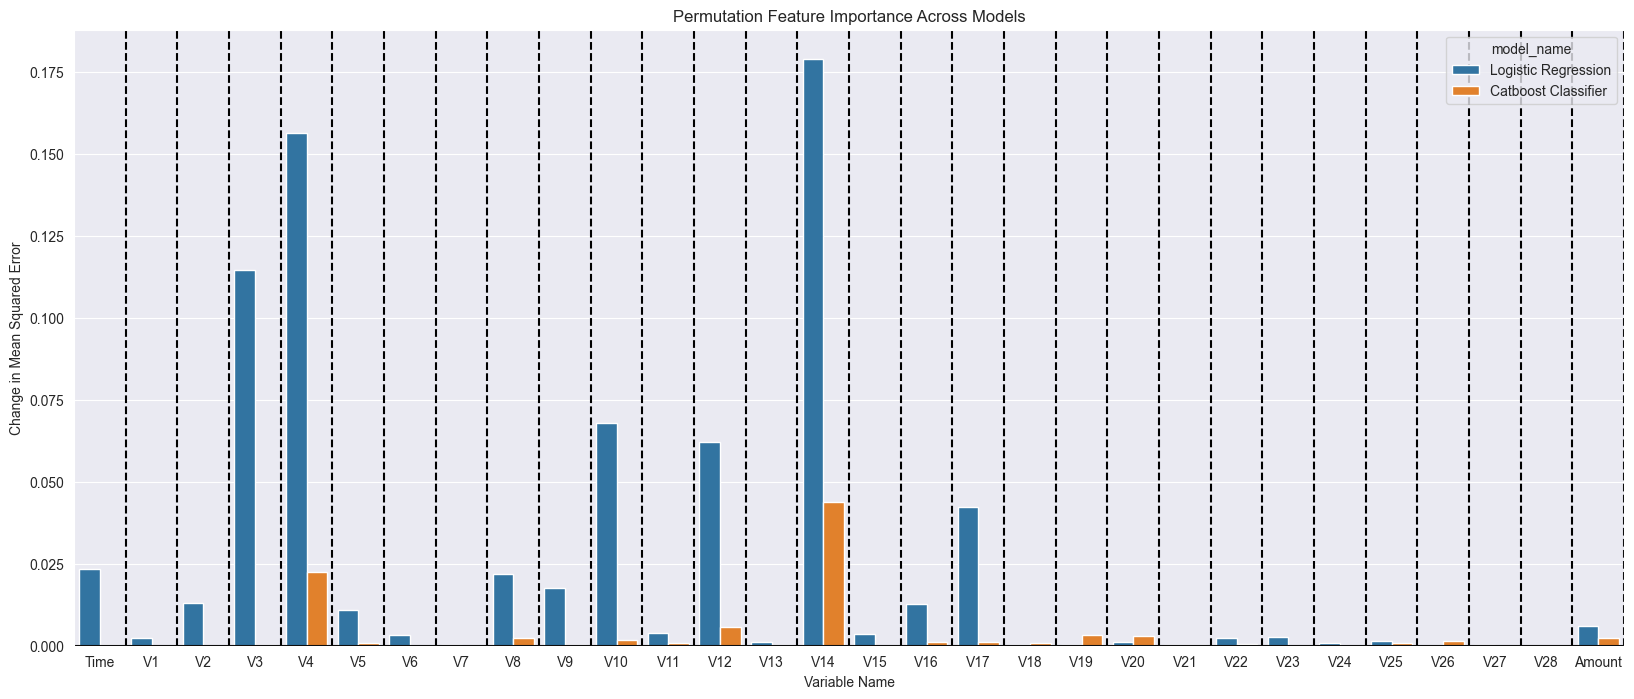

In [22]:
graph_data = {}
for result, name in zip(results_train, names):
    graph_data[name] = result['importances_mean']
    
graph_data = pd.DataFrame.from_dict(graph_data, orient='index', columns=feature_names)
graph_data.reset_index(inplace=True, drop=False)
graph_data.rename(columns={'index': 'model_name'}, inplace=True)
graph_data = graph_data.melt(id_vars='model_name')

plt.figure(figsize=[20,8])
plt.axhline(0, c='black')
[plt.axvline(i + 0.5, linestyle='--', c='black') for i in range(0, len(feature_names))]
sns.barplot(x=graph_data['variable'], y=graph_data['value'], hue=graph_data['model_name'])
plt.title("Permutation Feature Importance Across Models")
plt.xlabel("Variable Name")
plt.ylabel("Change in Mean Squared Error")

Text(0, 0.5, 'Change in Mean Squared Error')

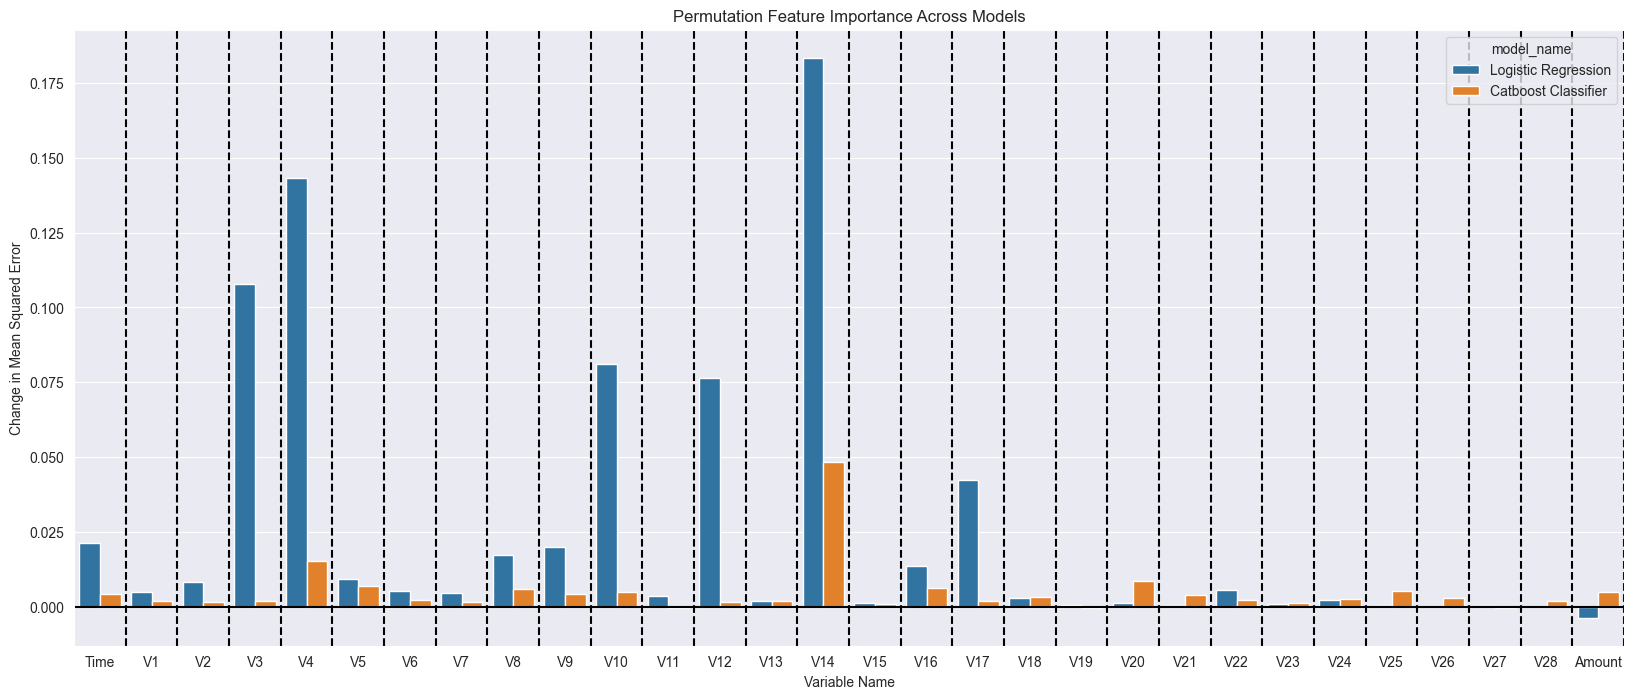

In [23]:
graph_data = {}
for result, name in zip(results_test, names):
    graph_data[name] = result['importances_mean']
    
graph_data = pd.DataFrame.from_dict(graph_data, orient='index', columns=feature_names)
graph_data.reset_index(inplace=True, drop=False)
graph_data.rename(columns={'index': 'model_name'}, inplace=True)
graph_data = graph_data.melt(id_vars='model_name')

plt.figure(figsize=[20,8])
plt.axhline(0, c='black')
[plt.axvline(i + 0.5, linestyle='--', c='black') for i in range(0, len(feature_names))]
sns.barplot(x=graph_data['variable'], y=graph_data['value'], hue=graph_data['model_name'])
plt.title("Permutation Feature Importance Across Models")
plt.xlabel("Variable Name")
plt.ylabel("Change in Mean Squared Error")

Показатели важности фичей между тренировочной и тестовой выборками схожи, поэтому можем вручную выделить наиболее коррелируемые признаки:

['V14', 'V4', 'V3', 'V10', 'V12', 'V17', 'V7', 'Time']

# Пересоздание выборок
Для дальнейшей работы понадобятся чистые тестовые наборы данных, поэтому смержим данные и поделим их снова

In [24]:
train = pd.concat([X_train_resampled, y_train_resampled], axis=1)
test = pd.concat([X_test_resampled, y_test_resampled], axis=1)
df_balanced = pd.concat([train, test], axis=0)
display(df_balanced)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
262611,160562.0,-0.371572,0.168118,0.617831,-1.694355,2.471142,4.204760,-0.162887,0.970896,0.462908,...,0.168302,0.678063,-0.505386,0.733575,0.850059,-0.020932,-0.165394,-0.284519,4.75,0
233189,147479.0,0.139616,1.091130,-1.166320,-0.490279,1.541530,-0.931480,1.582572,-0.394482,-0.314669,...,0.218804,0.892418,-0.360863,-1.037078,-0.159495,-0.356424,0.470180,0.276221,9.45,0
282472,170921.0,-0.391345,0.980357,-0.093822,-0.518776,0.157020,-1.120070,0.641591,0.243846,-0.223285,...,-0.195447,-0.563166,0.161527,-0.020038,-0.473551,0.144278,0.122489,0.020701,16.99,0
140036,83502.0,-0.754934,-1.802975,0.866239,-1.690596,-3.007219,1.865597,0.741822,0.098395,-1.798257,...,0.243652,1.268334,0.620800,-0.282679,-1.342805,-0.245118,0.375048,0.193864,533.50,0
5927,6536.0,1.260485,0.087736,-1.023824,0.471010,2.257944,3.654980,-0.527819,0.767821,1.457058,...,-0.332087,-0.668662,-0.117524,0.949007,0.868965,-0.365553,-0.001970,0.006576,11.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142159,68357.0,1.232604,-0.548931,1.087873,0.894082,-1.433055,-0.356797,-0.717492,0.003167,-0.100397,...,-0.448671,-0.517568,0.012833,0.699217,0.527258,-0.322607,0.080805,0.035427,19.59,1
142160,58067.0,-0.264869,3.386140,-3.454997,4.367629,3.336060,-2.053918,0.256890,-2.957235,-2.855797,...,-1.394504,-0.166029,-1.452081,-0.251815,1.243461,0.452787,0.132218,0.424599,1.00,1
142161,56650.0,-8.762083,2.791030,-7.682767,6.991214,-5.230695,-0.357388,-9.685621,1.749335,-4.495679,...,-0.090527,0.348590,0.051132,-0.415430,0.219665,0.330020,-0.028252,-0.156270,7.52,1
142162,64785.0,-8.744415,-3.420468,-4.850575,6.606846,-2.800546,0.105512,-3.269801,0.940378,-2.558691,...,0.102913,0.311626,-4.129195,0.034639,-1.133631,0.272265,1.841307,-1.796363,720.38,1


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop('Class', axis=1), df_balanced['Class'], test_size=0.25, random_state=0)

[Text(0, 0, '71454')]

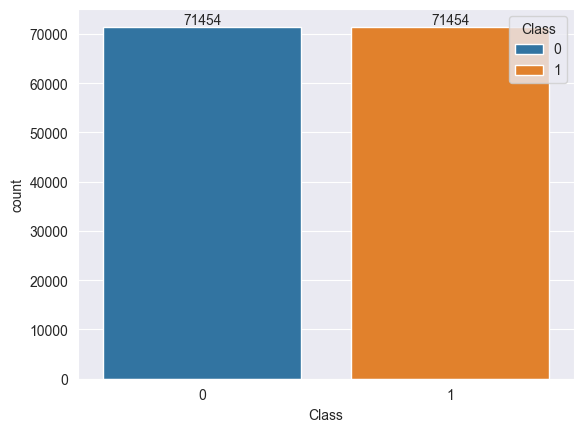

In [26]:
ax = sns.countplot(x='Class', data=df_balanced, hue='Class')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

# Обучение моделей
Построим 4 модели при момощи CatBoostClassifier на 4 отобранных ранее наборах фичей

### CatBoosting - ручной отбор

In [27]:
feature_names = ['V14', 'V4', 'V10', 'V12', 'V17', 'V8', 'V21', 'V3']
learn_params = {'iterations': 1000, 'use_best_model': True, 'eval_metric': 'Accuracy'}

In [28]:
X_train_handle, X_test_handle = X_train[feature_names], X_test[feature_names]

In [29]:
model_handle = CatBoostClassifier(**learn_params)
model_handle.fit(X_train_handle, y_train,
          eval_set=(X_test_handle, y_test),
          verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.100542
0:	learn: 0.9687071	test: 0.9692390	best: 0.9692390 (0)	total: 36.7ms	remaining: 36.7s
50:	learn: 0.9991416	test: 0.9992443	best: 0.9992443 (50)	total: 2.52s	remaining: 47s
100:	learn: 0.9993469	test: 0.9993282	best: 0.9993282 (85)	total: 4.99s	remaining: 44.4s
150:	learn: 0.9993935	test: 0.9993282	best: 0.9993842 (116)	total: 6.95s	remaining: 39.1s
200:	learn: 0.9994589	test: 0.9993562	best: 0.9993842 (116)	total: 9.41s	remaining: 37.4s
250:	learn: 0.9994589	test: 0.9993562	best: 0.9993842 (116)	total: 11.9s	remaining: 35.6s
300:	learn: 0.9994589	test: 0.9993562	best: 0.9993842 (116)	total: 13.3s	remaining: 30.9s
350:	learn: 0.9994682	test: 0.9993282	best: 0.9993842 (116)	total: 14.7s	remaining: 27.3s
400:	learn: 0.9994682	test: 0.9993282	best: 0.9993842 (116)	total: 16.4s	remaining: 24.5s
450:	learn: 0.9994682	test: 0.9993282	best: 0.9993842 (116)	total: 18s	remaining: 21.9s
500:	learn: 0.9994589	test: 0.9993282	best: 0.9993842 (116)	total: 19.3s	remaini

### CatBoosting - прямой отбор

In [30]:
feature_names = ['V5', 'V8', 'V13', 'V14', 'V22']
learn_params = {'iterations': 1000, 'use_best_model': True, 'eval_metric': 'Accuracy'}

In [31]:
X_train_forward, X_test_forward = X_train[feature_names], X_test[feature_names]

In [32]:
model_forward = CatBoostClassifier(**learn_params)
model_forward.fit(X_train_forward, y_train,
          eval_set=(X_test_forward, y_test),
          verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.100542
0:	learn: 0.9374609	test: 0.9382820	best: 0.9382820 (0)	total: 40ms	remaining: 40s
50:	learn: 0.9979474	test: 0.9982646	best: 0.9982646 (49)	total: 1.34s	remaining: 24.9s
100:	learn: 0.9988524	test: 0.9989084	best: 0.9989084 (95)	total: 2.9s	remaining: 25.8s
150:	learn: 0.9990203	test: 0.9988804	best: 0.9989364 (103)	total: 4.16s	remaining: 23.4s
200:	learn: 0.9992069	test: 0.9989084	best: 0.9989364 (103)	total: 5.42s	remaining: 21.6s
250:	learn: 0.9992723	test: 0.9989364	best: 0.9989364 (103)	total: 6.52s	remaining: 19.5s
300:	learn: 0.9992909	test: 0.9989364	best: 0.9989364 (103)	total: 7.47s	remaining: 17.3s
350:	learn: 0.9992723	test: 0.9989644	best: 0.9989644 (307)	total: 8.52s	remaining: 15.8s
400:	learn: 0.9992909	test: 0.9989644	best: 0.9989644 (307)	total: 9.52s	remaining: 14.2s
450:	learn: 0.9992909	test: 0.9989644	best: 0.9989644 (307)	total: 10.6s	remaining: 12.9s
500:	learn: 0.9992816	test: 0.9989644	best: 0.9989644 (307)	total: 11.5s	remainin

### CatBoosting - обратный отбор

In [33]:
feature_names = ['V2', 'V3', 'V4', 'V8', 'V10', 'V11', 'V14']
learn_params = {'iterations': 1000, 'use_best_model': True, 'eval_metric': 'Accuracy'}

In [34]:
X_train_backward, X_test_backward = X_train[feature_names], X_test[feature_names]

In [35]:
model_backward = CatBoostClassifier(**learn_params)
model_backward.fit(X_train_backward, y_train,
          eval_set=(X_test_backward, y_test),
          verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.100542
0:	learn: 0.9572592	test: 0.9572872	best: 0.9572872 (0)	total: 47.4ms	remaining: 47.4s
50:	learn: 0.9988617	test: 0.9987684	best: 0.9987684 (49)	total: 1.36s	remaining: 25.4s
100:	learn: 0.9993656	test: 0.9992443	best: 0.9992443 (74)	total: 2.59s	remaining: 23.1s
150:	learn: 0.9994589	test: 0.9992723	best: 0.9992723 (121)	total: 4.7s	remaining: 26.4s
200:	learn: 0.9994495	test: 0.9992723	best: 0.9992723 (121)	total: 6.17s	remaining: 24.5s
250:	learn: 0.9994589	test: 0.9993002	best: 0.9993002 (227)	total: 7.14s	remaining: 21.3s
300:	learn: 0.9994589	test: 0.9993002	best: 0.9993002 (227)	total: 8.01s	remaining: 18.6s
350:	learn: 0.9994589	test: 0.9993002	best: 0.9993002 (227)	total: 10.6s	remaining: 19.6s
400:	learn: 0.9994589	test: 0.9993002	best: 0.9993002 (227)	total: 12.8s	remaining: 19.1s
450:	learn: 0.9994589	test: 0.9993002	best: 0.9993002 (227)	total: 14.9s	remaining: 18.1s
500:	learn: 0.9994682	test: 0.9993002	best: 0.9993002 (227)	total: 16.6s	rema

### CatBoosting - permutation importance

In [36]:
feature_names = ['V14', 'V4', 'V3', 'V10', 'V12', 'V17', 'V7', 'Time']
learn_params = {'iterations': 1000, 'use_best_model': True, 'eval_metric': 'Accuracy'}

In [37]:
X_train_perm, X_test_perm = X_train[feature_names], X_test[feature_names]

In [38]:
model_perm = CatBoostClassifier(**learn_params)
model_perm.fit(X_train_perm, y_train,
          eval_set=(X_test_perm, y_test),
          verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.100542
0:	learn: 0.9633890	test: 0.9650125	best: 0.9650125 (0)	total: 33.4ms	remaining: 33.4s
50:	learn: 0.9992069	test: 0.9992443	best: 0.9992443 (50)	total: 1.49s	remaining: 27.7s
100:	learn: 0.9994029	test: 0.9992723	best: 0.9992723 (71)	total: 3.15s	remaining: 28s
150:	learn: 0.9994682	test: 0.9992723	best: 0.9992723 (71)	total: 4.38s	remaining: 24.6s
200:	learn: 0.9994868	test: 0.9993002	best: 0.9993002 (153)	total: 5.67s	remaining: 22.6s
250:	learn: 0.9994868	test: 0.9993002	best: 0.9993002 (153)	total: 6.73s	remaining: 20.1s
300:	learn: 0.9994868	test: 0.9993002	best: 0.9993002 (153)	total: 7.74s	remaining: 18s
350:	learn: 0.9994868	test: 0.9993002	best: 0.9993002 (153)	total: 8.68s	remaining: 16.1s
400:	learn: 0.9994868	test: 0.9993002	best: 0.9993002 (153)	total: 9.7s	remaining: 14.5s
450:	learn: 0.9994868	test: 0.9993002	best: 0.9993002 (153)	total: 10.7s	remaining: 13s
500:	learn: 0.9994868	test: 0.9993002	best: 0.9993002 (153)	total: 11.7s	remaining: 